<a href="https://colab.research.google.com/github/0larszl0/NU-Game-Jam/blob/main/KV6013_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KV6013 Brain Tumour Classification Project

**Student Name:** Huda Alshammari

**Student ID:** 22050935  
**Project:** Explainable AI for Brain Tumour Classification using Deep Learning  
**Models:** ResNet50 & EfficientNetB0 with Grad-CAM and SHAP

---

**Dataset 1:** Kaggle Brain Tumour MRI Dataset (7,023 images, 4 classes)

---
## Part 1: Environment Setup
---

In [1]:
# 1.1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1.2 Create Project Directory Structure
import os

PROJECT_ROOT = '/content/drive/MyDrive/KV6013_Project'

directories = [
    f'{PROJECT_ROOT}/data/brain_tumor_mri',
    f'{PROJECT_ROOT}/data/processed/train',
    f'{PROJECT_ROOT}/data/processed/val',
    f'{PROJECT_ROOT}/data/processed/test',
    f'{PROJECT_ROOT}/notebooks',
    f'{PROJECT_ROOT}/models/checkpoints',
    f'{PROJECT_ROOT}/outputs/gradcam',
    f'{PROJECT_ROOT}/outputs/shap',
    f'{PROJECT_ROOT}/outputs/figures'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f'Created: {directory}')

print('\nProject structure created!')

Created: /content/drive/MyDrive/KV6013_Project/data/brain_tumor_mri
Created: /content/drive/MyDrive/KV6013_Project/data/processed/train
Created: /content/drive/MyDrive/KV6013_Project/data/processed/val
Created: /content/drive/MyDrive/KV6013_Project/data/processed/test
Created: /content/drive/MyDrive/KV6013_Project/notebooks
Created: /content/drive/MyDrive/KV6013_Project/models/checkpoints
Created: /content/drive/MyDrive/KV6013_Project/outputs/gradcam
Created: /content/drive/MyDrive/KV6013_Project/outputs/shap
Created: /content/drive/MyDrive/KV6013_Project/outputs/figures

Project structure created!


In [3]:
# 1.3 Install Required Libraries
!pip install -q kagglehub opencv-python-headless
print('Packages installed!')

Packages installed!


In [4]:
# 1.4 Download Dataset using KaggleHub
import kagglehub
import shutil

DATA_DIR = f'{PROJECT_ROOT}/data/brain_tumor_mri'

# Check if already downloaded
if os.path.exists(f'{DATA_DIR}/Training') and len(os.listdir(f'{DATA_DIR}/Training')) == 4:
    print('Dataset already exists in Google Drive!')
else:
    print('Downloading dataset...')
    kaggle_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    print(f'Downloaded to: {kaggle_path}')

    print('Copying to Google Drive...')
    for item in os.listdir(kaggle_path):
        src = os.path.join(kaggle_path, item)
        dst = os.path.join(DATA_DIR, item)
        if os.path.isdir(src):
            if os.path.exists(dst):
                shutil.rmtree(dst)
            shutil.copytree(src, dst)
    print('Done!')

TRAIN_DIR = f'{DATA_DIR}/Training'
TEST_DIR = f'{DATA_DIR}/Testing'
print(f'\nTraining: {TRAIN_DIR}')
print(f'Testing: {TEST_DIR}')

Dataset already exists in Google Drive!

Training: /content/drive/MyDrive/KV6013_Project/data/brain_tumor_mri/Training
Testing: /content/drive/MyDrive/KV6013_Project/data/brain_tumor_mri/Testing


---
## Part 2: Configuration & Imports
---

In [5]:
# 2.1 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
import gc
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set seed
SEED = 42
np.random.seed(SEED)

print('Libraries imported!')

Libraries imported!


In [6]:
# 2.2 Configuration (Methodology Section 3.3)
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_CHANNELS = 3
NUM_CLASSES = 4

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

BATCH_SIZE = 32

PROCESSED_DIR = f'{PROJECT_ROOT}/data/processed'
FIGURES_DIR = f'{PROJECT_ROOT}/outputs/figures'

print(f'Image Size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}')
print(f'Split: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}')

Image Size: 224x224x3
Split: 0.7/0.15/0.15


---
## Part 3: Exploratory Data Analysis (Memory-Efficient)
---

In [7]:
# 3.1 Count images per class
def count_images(base_dir):
    counts = {}
    for cls in os.listdir(base_dir):
        path = os.path.join(base_dir, cls)
        if os.path.isdir(path):
            counts[cls.lower()] = len([f for f in os.listdir(path)
                                       if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print('Dataset Distribution:')
print('='*60)
total_all = 0
for cls in sorted(train_counts.keys()):
    total = train_counts[cls] + test_counts[cls]
    total_all += total
    print(f'{cls:<12} Train: {train_counts[cls]:>5}  Test: {test_counts[cls]:>4}  Total: {total:>5}')
print('-'*60)
print(f'TOTAL: {total_all} images')

Dataset Distribution:
glioma       Train:  1321  Test:  300  Total:  1621
meningioma   Train:  1339  Test:  306  Total:  1645
notumor      Train:  1593  Test:  405  Total:  1998
pituitary    Train:  1457  Test:  300  Total:  1757
------------------------------------------------------------
TOTAL: 7021 images


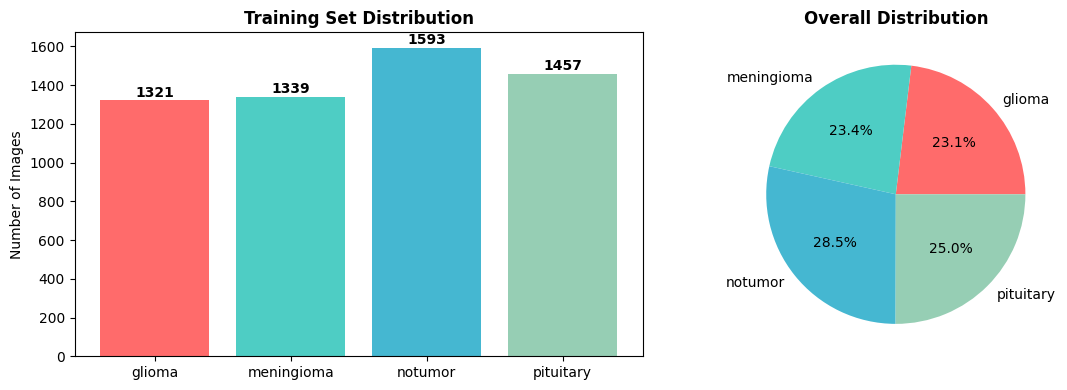

Saved: /content/drive/MyDrive/KV6013_Project/outputs/figures/class_distribution.png


In [8]:
# 3.2 Visualise class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

classes = sorted(train_counts.keys())
train_vals = [train_counts[c] for c in classes]
total_vals = [train_counts[c] + test_counts[c] for c in classes]

axes[0].bar(classes, train_vals, color=colours)
axes[0].set_title('Training Set Distribution', fontweight='bold')
axes[0].set_ylabel('Number of Images')
for i, v in enumerate(train_vals):
    axes[0].text(i, v+20, str(v), ha='center', fontweight='bold')

axes[1].pie(total_vals, labels=classes, autopct='%1.1f%%', colors=colours)
axes[1].set_title('Overall Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/class_distribution.png', dpi=150)
plt.show()
print(f'Saved: {FIGURES_DIR}/class_distribution.png')

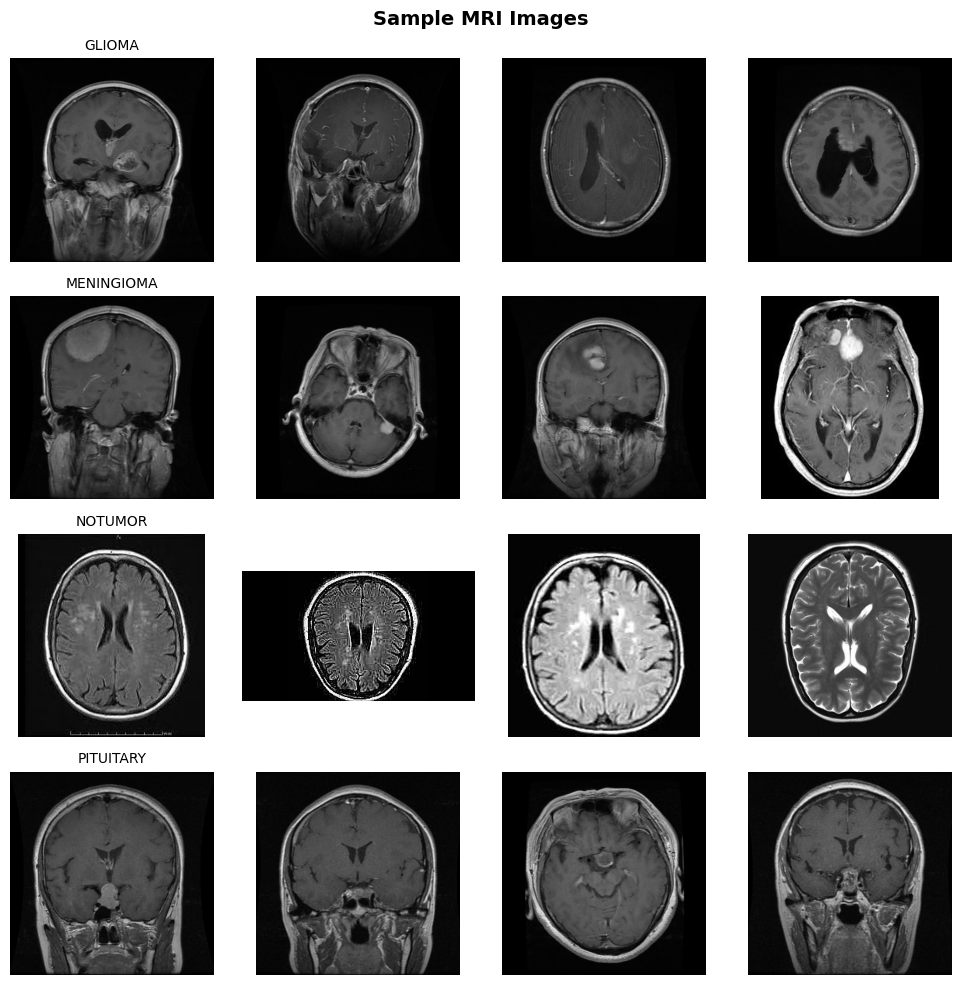

5199

In [9]:
# 3.3 Display sample images (load only a few)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Sample MRI Images', fontsize=14, fontweight='bold')

class_folders = sorted(os.listdir(TRAIN_DIR))
for row, cls in enumerate(class_folders):
    cls_path = os.path.join(TRAIN_DIR, cls)
    imgs = [f for f in os.listdir(cls_path) if f.endswith(('.jpg','.png'))][:4]

    for col, img_name in enumerate(imgs):
        img = cv2.imread(os.path.join(cls_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(cls.upper(), fontsize=10)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/sample_images.png', dpi=150)
plt.show()

# Clear memory
del img
gc.collect()

---
## Part 4: Create File Lists with Train/Val/Test Split
---

Instead of loading all images into RAM, we create lists of file paths and split those.

In [10]:
# 4.1 Collect all file paths and labels
def get_file_paths_and_labels(base_dirs):
    """
    Get file paths and labels without loading images.

    Args:
        base_dirs: List of directories to scan

    Returns:
        file_paths: List of image file paths
        labels: List of integer labels
        class_names: Sorted list of class names
    """
    file_paths = []
    labels = []

    # Get class names from first directory
    class_names = sorted([d for d in os.listdir(base_dirs[0])
                         if os.path.isdir(os.path.join(base_dirs[0], d))])
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for base_dir in base_dirs:
        for cls in class_names:
            cls_path = os.path.join(base_dir, cls)
            if not os.path.isdir(cls_path):
                continue

            for f in os.listdir(cls_path):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_paths.append(os.path.join(cls_path, f))
                    labels.append(label_map[cls])

    return file_paths, labels, class_names

# Get all file paths
print('Collecting file paths...')
all_paths, all_labels, class_names = get_file_paths_and_labels([TRAIN_DIR, TEST_DIR])

print(f'Total images: {len(all_paths)}')
print(f'Classes: {class_names}')
print(f'Label distribution: {np.bincount(all_labels)}')

Total images: 7021
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Label distribution: [1621 1645 1998 1757]


In [11]:
# 4.2 Create stratified split (70/15/15)
print('Creating stratified split...')
print(f'Target: {TRAIN_RATIO*100:.0f}% train, {VAL_RATIO*100:.0f}% val, {TEST_RATIO*100:.0f}% test')

# Convert to arrays for sklearn
all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

# First split: 15% test
paths_temp, paths_test, labels_temp, labels_test = train_test_split(
    all_paths, all_labels,
    test_size=TEST_RATIO,
    stratify=all_labels,
    random_state=SEED
)

# Second split: 15% val from remaining 85%
val_ratio_adj = VAL_RATIO / (1 - TEST_RATIO)
paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_temp, labels_temp,
    test_size=val_ratio_adj,
    stratify=labels_temp,
    random_state=SEED
)

print(f'\nSplit Results:')
print(f'  Train: {len(paths_train)} ({len(paths_train)/len(all_paths)*100:.1f}%)')
print(f'  Val:   {len(paths_val)} ({len(paths_val)/len(all_paths)*100:.1f}%)')
print(f'  Test:  {len(paths_test)} ({len(paths_test)/len(all_paths)*100:.1f}%)')

Creating stratified split...
Target: 70% train, 15% val, 15% test

Split Results:
  Train: 4914 (70.0%)
  Val:   1053 (15.0%)
  Test:  1054 (15.0%)


In [12]:
# 4.3 Verify stratification
print('Class distribution per split:')
print('-'*50)
for name, labels in [('Train', labels_train), ('Val', labels_val), ('Test', labels_test)]:
    counts = np.bincount(labels, minlength=NUM_CLASSES)
    dist = ', '.join([f'{class_names[i]}:{c}' for i, c in enumerate(counts)])
    print(f'{name}: {dist}')

Class distribution per split:
--------------------------------------------------
Train: glioma:1135, meningioma:1151, notumor:1398, pituitary:1230
Val: glioma:243, meningioma:247, notumor:300, pituitary:263
Test: glioma:243, meningioma:247, notumor:300, pituitary:264


---
## Part 5: Batch Processing & Saving
---

Process images in small batches to avoid RAM overflow.

In [13]:
# 5.1 Define batch processing function
def preprocess_and_save_batched(file_paths, labels, output_prefix, batch_size=500):
    """
    Process images in batches and save incrementally.

    Args:
        file_paths: Array of image file paths
        labels: Array of labels
        output_prefix: Prefix for output files
        batch_size: Number of images per batch
    """
    n_samples = len(file_paths)
    n_batches = (n_samples + batch_size - 1) // batch_size

    all_images = []
    all_labels = []

    print(f'Processing {n_samples} images in {n_batches} batches...')

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)

        batch_paths = file_paths[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        batch_images = []
        for path in batch_paths:
            try:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_LANCZOS4)
                img = img.astype(np.float32) / 255.0
                batch_images.append(img)
            except Exception as e:
                print(f'Error: {path} - {e}')

        all_images.extend(batch_images)
        all_labels.extend(batch_labels)

        print(f'  Batch {batch_idx+1}/{n_batches}: {len(batch_images)} images processed')

        # Clear batch from memory
        del batch_images
        gc.collect()

    # Convert to arrays and save
    X = np.array(all_images, dtype=np.float32)
    y = np.array(all_labels, dtype=np.int32)

    print(f'Saving {output_prefix}...')
    np.save(f'{output_prefix}_X.npy', X)
    np.save(f'{output_prefix}_y.npy', y)

    print(f'Saved: {X.shape}, {y.shape}')

    # Clear memory
    del all_images, all_labels, X, y
    gc.collect()

    return True

print('Batch processing function defined!')

Batch processing function defined!


In [14]:
# 5.2 Process and save training set
print('='*60)
print('PROCESSING TRAINING SET')
print('='*60)
preprocess_and_save_batched(
    paths_train, labels_train,
    f'{PROCESSED_DIR}/train',
    batch_size=500
)

PROCESSING TRAINING SET
Processing 4914 images in 10 batches...
  Batch 1/10: 500 images processed
  Batch 2/10: 500 images processed
  Batch 3/10: 500 images processed
  Batch 4/10: 500 images processed
  Batch 5/10: 500 images processed
  Batch 6/10: 500 images processed
  Batch 7/10: 500 images processed
  Batch 8/10: 500 images processed
  Batch 9/10: 500 images processed
  Batch 10/10: 414 images processed
Saving /content/drive/MyDrive/KV6013_Project/data/processed/train...
Saved: (4914, 224, 224, 3), (4914,)


True

In [15]:
# 5.3 Process and save validation set
print('='*60)
print('PROCESSING VALIDATION SET')
print('='*60)
preprocess_and_save_batched(
    paths_val, labels_val,
    f'{PROCESSED_DIR}/val',
    batch_size=500
)

PROCESSING VALIDATION SET
Processing 1053 images in 3 batches...
  Batch 1/3: 500 images processed
  Batch 2/3: 500 images processed
  Batch 3/3: 53 images processed
Saving /content/drive/MyDrive/KV6013_Project/data/processed/val...
Saved: (1053, 224, 224, 3), (1053,)


True

In [1]:
# 5.4 Process and save test set
print('='*60)
print('PROCESSING TEST SET')
print('='*60)
preprocess_and_save_batched(
    paths_test, labels_test,
    f'{PROCESSED_DIR}/test',
    batch_size=500
)

PROCESSING TEST SET


NameError: name 'preprocess_and_save_batched' is not defined

In [17]:
# 5.5 Save configuration
config = {
    'img_height': IMG_HEIGHT,
    'img_width': IMG_WIDTH,
    'img_channels': IMG_CHANNELS,
    'num_classes': NUM_CLASSES,
    'class_names': class_names,
    'train_samples': len(labels_train),
    'val_samples': len(labels_val),
    'test_samples': len(labels_test),
    'batch_size': BATCH_SIZE,
    'seed': SEED
}

with open(f'{PROCESSED_DIR}/config.json', 'w') as f:
    json.dump(config, f, indent=2)

print('Configuration saved!')
print(json.dumps(config, indent=2))

Configuration saved!
{
  "img_height": 224,
  "img_width": 224,
  "img_channels": 3,
  "num_classes": 4,
  "class_names": [
    "glioma",
    "meningioma",
    "notumor",
    "pituitary"
  ],
  "train_samples": 4914,
  "val_samples": 1053,
  "test_samples": 1054,
  "batch_size": 32,
  "seed": 42
}


In [ ]:
# 5.6 List saved files
print('\nSaved files:')
print('-'*50)
for f in sorted(os.listdir(PROCESSED_DIR)):
    fpath = os.path.join(PROCESSED_DIR, f)
    if os.path.isfile(fpath):
        size = os.path.getsize(fpath) / (1024*1024)
        print(f'  {f}: {size:.1f} MB')

---
## Part 6: Verify Saved Data
---

Verifying saved data...
Train - X: (4914, 224, 224, 3), y: (4914,)
        Range: [0.000, 1.000]


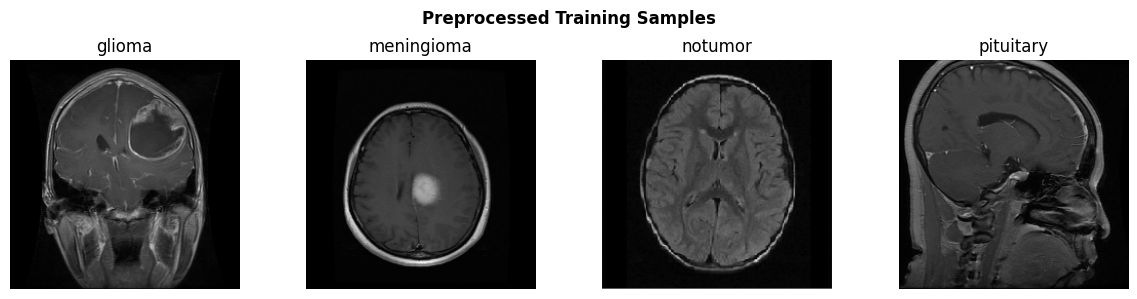


Verification complete!


In [19]:
# 6.1 Load and verify (load one at a time to save memory)
print('Verifying saved data...')
print('='*50)

# Load training data
X_train = np.load(f'{PROCESSED_DIR}/train_X.npy')
y_train = np.load(f'{PROCESSED_DIR}/train_y.npy')
print(f'Train - X: {X_train.shape}, y: {y_train.shape}')
print(f'        Range: [{X_train.min():.3f}, {X_train.max():.3f}]')

# Display sample
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle('Preprocessed Training Samples', fontweight='bold')
for i in range(4):
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(X_train[idx])
    axes[i].set_title(class_names[i])
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/preprocessed_samples.png', dpi=150)
plt.show()

del X_train, y_train
gc.collect()
print('\nVerification complete!')

---
## Part 7: Data Augmentation Configuration
---

In [20]:
# 7.1 Define augmentation (for use in training notebook)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training augmentation (Methodology Section 3.3)
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for val/test
val_test_datagen = ImageDataGenerator()

print('Augmentation Configuration:')
print('  - Rotation: ±40°')
print('  - Width/Height shift: ±20%')
print('  - Zoom: ±20%')
print('  - Horizontal flip: Yes')

Augmentation Configuration:
  - Rotation: ±40°
  - Width/Height shift: ±20%
  - Zoom: ±20%
  - Horizontal flip: Yes


In [ ]:
# 7.2 Visualise augmentation
X_train = np.load(f'{PROCESSED_DIR}/train_X.npy')
sample = X_train[0:1]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Augmentation Examples', fontweight='bold')

axes[0,0].imshow(sample[0])
axes[0,0].set_title('Original')
axes[0,0].axis('off')

aug_iter = train_datagen.flow(sample, batch_size=1)
for i in range(1, 10):
    aug = np.clip(next(aug_iter)[0], 0, 1)
    axes[i//5, i%5].imshow(aug)
    axes[i//5, i%5].set_title(f'Aug {i}')
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/augmentation_examples.png', dpi=150)
plt.show()

del X_train, sample
gc.collect()

---
## Part 8: Load Function for Future Notebooks
---

In [ ]:
# 8.1 Define load function (COPY THIS TRAINING NOTEBOOK)
def load_preprocessed_data(processed_dir):
    """
    Load preprocessed data from saved numpy files.

    Usage:
        X_train, y_train, X_val, y_val, X_test, y_test, config =
            load_preprocessed_data(PROCESSED_DIR)
    """
    import numpy as np
    import json
    from tensorflow.keras.utils import to_categorical

    X_train = np.load(f'{processed_dir}/train_X.npy')
    y_train = np.load(f'{processed_dir}/train_y.npy')
    X_val = np.load(f'{processed_dir}/val_X.npy')
    y_val = np.load(f'{processed_dir}/val_y.npy')
    X_test = np.load(f'{processed_dir}/test_X.npy')
    y_test = np.load(f'{processed_dir}/test_y.npy')

    with open(f'{processed_dir}/config.json') as f:
        config = json.load(f)

    # Convert to one-hot
    num_classes = config['num_classes']
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    print(f'Loaded: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}')
    return X_train, y_train, X_val, y_val, X_test, y_test, config

print('Load function defined!')
print('\nCopy this function to your Week 3 notebook.')

---
## Summary
---

### Completed:
- ✅ Environment setup
- ✅ Dataset download (7,023 images)
- ✅ EDA with visualisations
- ✅ Memory-efficient preprocessing
- ✅ 70/15/15 stratified split
- ✅ Data saved to Google Drive
- ✅ Augmentation configured

### Next Steps:
1. Create Week 3 notebook for model training
2. Implement ResNet50 and EfficientNetB0
3. Train with the saved data